In [1]:
from typing import Any

import time

from pathlib import Path
import shutil

from datetime import datetime

import yaml

import math
import numpy as np

from PIL import Image, ImageOps
import albumentations as A
import cv2

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score, precision_recall_curve, roc_curve

import mlflow
import mlflow.pytorch as ml_pt

from project_modules import (get_new_image_size, get_borders_size, modify_image, prep_images, mlflow_log_figure, create_learning_curves_dict, 
                             ImageModifier, MyResNet34, MyResNet50, ToTensorWithGrad, TargetTransform, TrainingSupervisor)

### Running Mlflow (Run in Ants-Bees-Recognition-Project)

In [2]:
experiment_name = "Ants Bees Recognition Project"

In [3]:
try:
    exp_id = mlflow.create_experiment(name=experiment_name, tags={"Type": "project"})
except:
    exp_id = mlflow.get_experiment_by_name(name=experiment_name).experiment_id

mlflow.set_experiment(experiment_name=experiment_name)

<Experiment: artifact_location='file:///home/macwoj/playground/machine_learning_book/Ants-Bees-Recognition-Project/mlruns/268962542675260621', creation_time=1720727210636, experiment_id='268962542675260621', last_update_time=1720727210636, lifecycle_stage='active', name='Ants Bees Recognition Project', tags={'Type': 'project'}>

### Check some image properties

In [4]:
data_path = Path("hymenoptera_data")

path_train = data_path/"train"
path_val = data_path/"val"
path_test = data_path/"test"

path_train_mod = data_path/"train_mod"
path_val_mod = data_path/"val_mod"
path_test_mod = data_path/"test_mod"

path_train_bees = path_train/"bees"
path_train_ants = path_train/"ants"
path_val_bees = path_val/"bees"
path_val_ants = path_val/"ants"
path_test_bees = path_test/"bees"
path_test_ants = path_test/"ants"

path_train_bees_mod = data_path/"train_mod"/"bees"
path_train_ants_mod = data_path/"train_mod"/"ants"
path_val_bees_mod = data_path/"val_mod"/"bees"
path_val_ants_mod = data_path/"val_mod"/"ants"
path_test_bees_mod = data_path/"test_mod"/"bees"
path_test_ants_mod = data_path/"test_mod"/"ants"

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [6]:
max_w = 0
max_h = 0
min_w = math.inf
min_h = math.inf

for im_path in path_train_bees.iterdir():
    im = Image.open(im_path)
    w, h = im.size
    max_w = w if w > max_w else max_w
    max_h = h if h > max_h else max_h
    min_w = w if w < min_w else min_w
    min_h = h if h < min_h else min_h
    if w != 500 and h != 500:
        print(im_path)
print(f"max width: {max_w}, max height: {max_h}")
print(f"min width: {min_w}, min height: {min_h}")

hymenoptera_data/train/bees/a11.jpeg
hymenoptera_data/train/bees/a22.jpeg
hymenoptera_data/train/bees/a44.jpeg
hymenoptera_data/train/bees/a62.jpeg
hymenoptera_data/train/bees/93.jpeg
hymenoptera_data/train/bees/a73.jpeg
hymenoptera_data/train/bees/a63.jpeg
hymenoptera_data/train/bees/a131.jpeg
hymenoptera_data/train/bees/a110.jpeg
hymenoptera_data/train/bees/90.jpeg
hymenoptera_data/train/bees/2610833167_79bf0bcae5.jpg
hymenoptera_data/train/bees/a75.jpeg
hymenoptera_data/train/bees/a9.jpeg
hymenoptera_data/train/bees/a71.jpeg
hymenoptera_data/train/bees/a98.jpeg
hymenoptera_data/train/bees/a52.jpeg
hymenoptera_data/train/bees/a69.jpeg
hymenoptera_data/train/bees/a51.jpeg
hymenoptera_data/train/bees/a8.jpeg
hymenoptera_data/train/bees/a42.jpeg
hymenoptera_data/train/bees/a50.jpeg
hymenoptera_data/train/bees/a54.jpeg
hymenoptera_data/train/bees/a38.jpeg
hymenoptera_data/train/bees/a94.jpeg
hymenoptera_data/train/bees/a136.jpeg
hymenoptera_data/train/bees/a100.jpeg
hymenoptera_data/trai

In [7]:
im_path1 = path_train_bees/"2610833167_79bf0bcae5.jpg"
im_path2 = path_train_bees/"2781170484_5d61835d63.jpg"
im_path3 = "hymenoptera_data/val/ants/43.jpeg"

im1 = Image.open(im_path1)
im2 = Image.open(im_path2)
im3 = Image.open(im_path3)

In [8]:
im1.width, im1.height

(311, 387)

In [9]:
im2.width, im2.height

(486, 429)

214 95


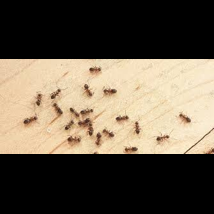

In [10]:
image_mod = modify_image(image=im3)
image_mod

### Prepare images

In [11]:
# image_modifier = ImageModifier(desired_wh=224)
# im_mod = image_modifier.modify_image(image=im3, add_borders=False)
# im_mod

In [12]:
# image_modifier = ImageModifier(desired_wh=224)

# alb_trans = A.Compose([
#                     #    A.Resize(width=250, height=250), 
#                     #    A.RandomCrop(width=214, height=214), 
#                        A.Rotate(limit=40, p=0.1, border_mode=cv2.BORDER_CONSTANT), 
#                        A.HorizontalFlip(p=0.5),
#                        A.VerticalFlip(p=0.05), 
#                        A.Blur(blur_limit=3, p=0.05), 
#                        A.OneOf([
#                                 # A.ColorJitter(p=0.5),
#                                 A.RGBShift(r_shift_limit=10, g_shift_limit=10, b_shift_limit=10)
#                                 ], p=1.0)
#                        ])


# original_files_dirs = [path_train_bees, path_train_ants]
# modified_files_dirs = [path_train_bees_mod, path_train_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier, alb_trans, True)

# original_files_dirs = [path_val_bees, path_val_ants]
# modified_files_dirs = [path_val_bees_mod, path_val_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier)

# original_files_dirs = [path_test_bees, path_test_ants]
# modified_files_dirs = [path_test_bees_mod, path_test_ants_mod]

# prep_images(original_files_dirs, modified_files_dirs, image_modifier)

### Show exapmle of modified image

In [13]:
# Use this to experiment with some other albumentations transforms
# # alb_trans = A.Compose([A.Resize(width=250, height=250), 
# #                        A.RandomCrop(width=214, height=214), 
# #                        A.Rotate(limit=40, p=0.9, border_mode=cv2.BORDER_CONSTANT), 
# #                        A.HorizontalFlip(p=0.5),
# #                        A.VerticalFlip(p=0.05), 
# #                        A.OneOf([
# #                                 A.Blur(blur_limit=3), 
# #                                 A.ColorJitter(p=0.5),
# #                                 A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25)
# #                                 ], p=1.0)
# #                        ])


# mod_bee_path = path_train_bees/"16838648_415acd9e3f.jpg"
# mod_bee = Image.open(mod_bee_path)
# mod_bee = image_modifier.modify_image(image=mod_bee, add_borders=False)
# mod_bee = np.array(mod_bee)
# mod_bee = alb_trans(image=mod_bee)
# mod_bee = mod_bee["image"]
# plt.imshow(mod_bee)
# plt.show()

### Prepare Pytorch datasets and dataloaders

In [14]:
# The same as transforms.ToTensor() but sets requires_grad == True
dataset_transform = ToTensorWithGrad()
# dataset_transform = transforms.ToTensor()

train_dataset = ImageFolder(root=path_train_mod, transform=dataset_transform, target_transform=TargetTransform())
val_dataset = ImageFolder(root=path_val_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())

train_dataloader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

In [15]:
len(train_dataloader), len(val_dataloader), len(test_dataloader)

(68, 6, 5)

In [16]:
len(train_dataloader.dataset)

2176

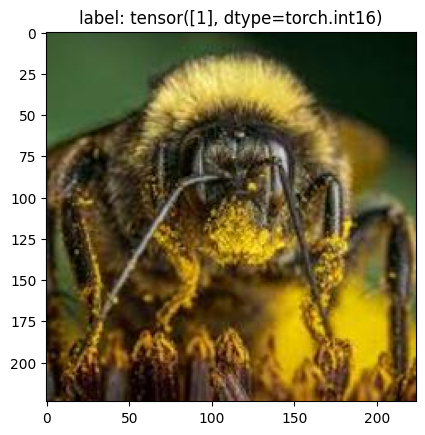

In [17]:
batch = (next(iter(val_dataloader)))
test_picture = batch[0][0].detach().numpy()
test_label = batch[1][0].short()
test_picture = np.transpose(test_picture, axes=(1, 2, 0))
plt.imshow(test_picture)
plt.title(f"label: {test_label}")
plt.show()

### Check dataloaders

In [18]:
# X, y = next(iter(train_dataloader))
# outputs = my_resnet(X)
# outputs.shape, y.shape

In [19]:
# labels = torch.tensor([[1]*32], dtype=torch.float).T
# loss_fn = nn.BCEWithLogitsLoss()
# loss = loss_fn(outputs, labels)
# loss

### Check TrainingSupervisor class

In [20]:
# path=Path("./checkpoints/checkpoint.pth")
# model=MyResNet34().to(device)
# supervisor = TrainingSupervisor(model=model, early_stop_patience=5, lr=0.01, lr_patience=2, lr_reduce_factor = 2, checkpoints_default_filepath=path)
# supervisor.save_model_state_dict()

### Check the model - try overfitting single training minibatch and logging the results to mlflow

In [21]:
# batch_size = 1

# # dataset_transform = transforms.ToTensor()
# dataset_transform = ToTensorWithGrad()

# train_dataset = ImageFolder(root=path_train_mod, transform=dataset_transform, target_transform=TargetTransform())
# val_dataset = ImageFolder(root=path_val_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())
# test_dataset = ImageFolder(root=path_test_mod, transform=transforms.ToTensor(), target_transform=TargetTransform())

In [22]:
# model = MyResNet50()
# model.to(device)
# path=Path("./checkpoints/checkpoint.pth")
# lr = 0.01
# supervisor = TrainingSupervisor(model=model, early_stop_patience=3, lr=lr, lr_patience=2, lr_reduce_factor = 2, checkpoints_default_filepath=path)
# loss_fn = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [23]:
# n_epochs = 20
# batch_size = 14

# train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# val_dataloader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=True)
# test_dataloader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)

# plots_x_axis = np.array([])
# training_losses = np.array([])
# validation_losses = np.array([])
# accuracies = np.array([])
# learning_rates = np.array([])



# batch = (next(iter(train_dataloader)))
# X, y = batch[0], batch[1]
# X, y = X.to(device), y.to(device)


# with mlflow.start_run() as run:
#     run_id = run.info.run_id
#     for epoch in range(1, n_epochs+1):
#         print(f"\nEpoch {epoch}/{n_epochs}")
# # ========================================================================
#         outputs = model(X)
#         loss = loss_fn(outputs, y)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
# # ========================================================================

#         print(f"Training loss: {loss:.2f}")

### Check the model performance, perform full training and evaluating scenario

In [24]:
# loaded_state_dict = ml_pt.load_state_dict(state_dict_uri="mlruns/268962542675260621/f74e570265ba4458b5c8afd25ecd02ce/artifacts/model_artifacts")
# model = MyResNet34()
# model.load_state_dict(state_dict=loaded_state_dict)

if device == "cuda":
    torch.cuda.empty_cache()
model = MyResNet50()

In [25]:
path=Path("./checkpoints/checkpoint.pth")
lr = 0.01
supervisor = TrainingSupervisor(model=model, early_stop_patience=25, lr=lr, lr_patience=8, lr_reduce_factor=2, checkpoints_default_filepath=path)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)

In [33]:
n_epochs = 1000

batch_size = 26
if model._get_name() == "MyResNet34":
    batch_size = 26
elif model._get_name() == "MyResNet50":
    batch_size = 12
    
model.to(device)

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)
len_dataloader = len(train_dataloader)

epochs = np.array([])
train_losses = np.array([])
val_losses = np.array([])
train_accuracies = np.array([])
val_accuracies = np.array([])
learning_rates = np.array([])

ml_pt.autolog(disable=False)
try:
    with mlflow.start_run() as run:
        params_dict = {"Model architecture": model._get_name(), "Batch size": batch_size, 
                       "Train dataset size": len(train_dataloader.dataset), 
                       "Validation dataset size": len(val_dataloader.dataset), "No. of augmentations per image": 3}
        mlflow.log_params(params=params_dict)
        run_id = run.info.run_id
        for epoch in range(1, n_epochs+1):
            print(f"\nEpoch {epoch}/{n_epochs}")
    # ========================================================================
            for idx, (X, y) in enumerate(train_dataloader):
                print(f"Step {idx + 1}/{len_dataloader}")
                X, y = X.to(device), y.to(device)
                outputs = model(X)
                loss = loss_fn(outputs, y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
    # ========================================================================
            print("Evaluating model performance...")
            train_accuracy, train_loss_sum = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=train_dataloader, device=device)
            val_accuracy, val_loss_sum = supervisor.check_accuracy(loss_fn=loss_fn, dataloader=val_dataloader, device=device)

            lr = supervisor.lr

            mlflow.log_metrics(metrics={"Epoch": epoch, "Training loss": train_loss_sum, 
                                        "Validaion loss": val_loss_sum, "Training accuracy": train_accuracy, 
                                        "Validation accuracy": val_accuracy, "Learning rate": lr})

            epochs = np.append(epochs, epoch)
            train_losses = np.append(train_losses, train_loss_sum)
            val_losses = np.append(val_losses, val_loss_sum)
            train_accuracies = np.append(train_accuracies, train_accuracy)
            val_accuracies = np.append(val_accuracies, val_accuracy)
            learning_rates = np.append(learning_rates, lr)

            mlflow_log_figure(X=epochs, Y=train_losses, artifact_file="plots/learning_curves.png", 
                            Y2=val_losses, title="learning curves", xlabel="epoch", 
                            ylabel="loss values", legend=["train loss", "val loss"])
            
            mlflow_log_figure(X=epochs, Y=train_accuracies, artifact_file="plots/accuracies.png", 
                                Y2=val_accuracies, title="training and validation accuracies", xlabel="epoch", 
                                ylabel="accuracy", legend=["training accuracy", "validation accuracy"])

            mlflow_log_figure(X=epochs, Y=learning_rates, artifact_file="plots/learning_rate.png", 
                        title="learning rate", xlabel="epoch", ylabel="lr")
            
            print("\n")
            print(f"Training accuracy: {train_accuracy:.2f}%")
            print(f"Validation accuracy: {val_accuracy:.2f}%")
            print(f"Training loss: {train_loss_sum:.5f}")
            print(f"Validation loss: {val_loss_sum:.5f}")
            print(f"lr: {lr}")
            
            save_state_dict = supervisor.update_patience_counters(current_val_loss=val_loss_sum)
            early_stop = supervisor.early_stop()

            new_lr = supervisor.update_lr()
            optimizer.param_groups[0]['lr'] = new_lr

            if save_state_dict:
                supervisor.mlflow_save_model_state_dict(artifact_path="model_artifacts")
                mlflow.log_metric(key="Number of checkpoints", value=supervisor.mlflow_model_checkpoints_saved)

            elif early_stop:
                learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
                mlflow.set_tag(key="Exited by", value="Early Stop")
                mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json")
                break
        if not early_stop:
            print("Finished all epochs")
            learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
            mlflow.set_tag(key="Exited by", value="Finished all epochs")
            mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json")

# Log the metadata in case of keyboard interrupt or other error
except KeyboardInterrupt:
    print("Keyboard Interrupt occurred")
    learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
    mlflow.start_run(run_id=run_id, experiment_id=exp_id)
    mlflow.set_tag(key="Exited by", value="Keyboard Interrupt")
    mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json", run_id=run_id)
    mlflow.end_run(status="FINISHED")

except RuntimeError as e:
    if "out of memory" in str(e):
        learning_curves_dict = create_learning_curves_dict(epochs, train_losses, val_losses, train_accuracies, val_accuracies, learning_rates)
        print("Out of Memory Error")
        mlflow.start_run(run_id=run_id, experiment_id=exp_id)
        mlflow.set_tag(key="Exited by", value="Out of Memory Error")
        mlflow.log_table(data=learning_curves_dict, artifact_file="training_metadata/data_dictionary.json", run_id=run_id)
        mlflow.end_run(status="FAILED")

2024/07/16 10:47:04 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.



Epoch 1/1000
Step 1/84
Step 2/84
Step 3/84
Step 4/84
Step 5/84
Step 6/84
Step 7/84
Step 8/84
Step 9/84
Step 10/84
Step 11/84
Step 12/84
Step 13/84
Step 14/84
Step 15/84
Step 16/84
Step 17/84
Step 18/84
Step 19/84
Step 20/84
Step 21/84
Step 22/84
Step 23/84
Step 24/84
Step 25/84
Step 26/84
Step 27/84
Step 28/84
Step 29/84
Step 30/84
Step 31/84
Step 32/84
Step 33/84
Step 34/84
Step 35/84
Step 36/84
Step 37/84
Step 38/84
Step 39/84
Step 40/84
Step 41/84
Step 42/84
Step 43/84
Step 44/84
Step 45/84
Step 46/84
Step 47/84
Step 48/84
Step 49/84
Step 50/84
Step 51/84
Step 52/84
Step 53/84
Step 54/84
Step 55/84
Step 56/84
Step 57/84
Step 58/84
Step 59/84
Step 60/84
Step 61/84
Step 62/84
Step 63/84
Step 64/84
Step 65/84
Step 66/84
Step 67/84
Step 68/84
Step 69/84
Step 70/84
Step 71/84
Step 72/84
Step 73/84
Step 74/84
Step 75/84
Step 76/84
Step 77/84
Step 78/84
Step 79/84
Step 80/84
Step 81/84
Step 82/84
Step 83/84
Step 84/84


/home/maciej/programming/machine_learning_book/.pytorch2/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluating model performance...


Training accuracy: 62.59%
Validation accuracy: 58.24%
Training loss: 0.03208
Validation loss: 0.03636
lr: 0.01
Saving model...

Epoch 2/1000
Step 1/84
Step 2/84
Step 3/84
Step 4/84
Step 5/84
Step 6/84
Step 7/84
Step 8/84
Step 9/84
Step 10/84
Step 11/84
Step 12/84
Step 13/84
Step 14/84
Step 15/84
Step 16/84
Step 17/84
Step 18/84
Step 19/84
Step 20/84
Step 21/84
Step 22/84
Step 23/84
Step 24/84
Step 25/84
Step 26/84
Step 27/84
Step 28/84
Step 29/84
Step 30/84
Step 31/84
Step 32/84
Step 33/84
Step 34/84
Step 35/84
Step 36/84
Step 37/84
Step 38/84
Step 39/84
Step 40/84
Step 41/84
Step 42/84
Step 43/84
Step 44/84
Step 45/84
Step 46/84
Step 47/84
Step 48/84
Step 49/84
Step 50/84
Step 51/84
Step 52/84
Step 53/84
Step 54/84
Step 55/84
Step 56/84
Step 57/84
Step 58/84
Step 59/84
Step 60/84
Step 61/84
Step 62/84
Step 63/84
Step 64/84
Step 65/84
Step 66/84
Step 67/84
Step 68/84
Step 69/84
Step 70/84
Step 71/84
Step 72/84
Step 73/84
Step 74/84
Step 75/84
Step 76/8